<a href="https://colab.research.google.com/github/vipin-jangra/face-age-estimation-CNN/blob/main/D2_CNN1_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import re
import cv2
import keras
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.applications.resnet50 import preprocess_input

In [3]:
def preprocess_image(image_path):
    # Read grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize image to (224, 224)
    image = cv2.resize(image, (224, 224))
    # Convert grayscale to RGB by stacking the single channel
    image_rgb = np.stack((image,) * 3, axis=-1)
    # Preprocess image for ResNet50 model
    image_rgb = preprocess_input(image_rgb)
    return image_rgb

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Define age group conversion
def age_to_range(age):
    return age // 3 # Convert ages to 3-year interval indices

In [6]:
def preprocess_labels(labels, num_classes):
    # One-hot encode labels
    labels = to_categorical(labels, num_classes=num_classes)
    return labels

In [8]:
# Load and preprocess the dataset
image_dir = '/content/drive/MyDrive/Dataset/Dataset2/FGNET/images'
images=[]
image_paths = []
age_labels = []
age_groups = []
target_size = (224, 224)

for filename in os.listdir(image_dir):
  if filename.endswith(".JPG"):
    match = re.search(r'A(\d+)', filename)
    age_str = match.group(1)
    age = int(age_str)
    range_index = age_to_range(age)
    age_labels.append(range_index)

    image_path = os.path.join(image_dir, filename)
    image = preprocess_image(image_path)
    images.append(image)
    image_paths.append(image_path)

images = np.array(images)
age_groups = age_labels
age_labels = preprocess_labels(age_labels, np.max(age_groups)+1)

In [9]:
# Print shapes
print(f"Images shape: {images.shape}")
print(f"Labels shape: {age_labels.shape}")

Images shape: (1002, 224, 224, 3)
Labels shape: (1002, 24)


In [10]:
def age_group_to_interval(group_index, interval=3):
    start = group_index * interval
    end = (group_index + 1) * interval - 1
    return f"{start}-{end}"

In [11]:
import pandas as pd
df = pd.DataFrame()
age_intervals = [age_group_to_interval(age) for age in age_groups]
df['images_path'],df['age'] = image_paths,age_intervals
df.head(10)

,images_path,age
0,/content/drive/MyDrive/Dataset/Dataset2/FGNET/...,6-8
1,/content/drive/MyDrive/Dataset/Dataset2/FGNET/...,0-2
2,/content/drive/MyDrive/Dataset/Dataset2/FGNET/...,9-11
3,/content/drive/MyDrive/Dataset/Dataset2/FGNET/...,3-5
4,/content/drive/MyDrive/Dataset/Dataset2/FGNET/...,42-44
5,/content/drive/MyDrive/Dataset/Dataset2/FGNET/...,18-20
6,/content/drive/MyDrive/Dataset/Dataset2/FGNET/...,30-32
7,/content/drive/MyDrive/Dataset/Dataset2/FGNET/...,51-53
8,/content/drive/MyDrive/Dataset/Dataset2/FGNET/...,57-59
9,/content/drive/MyDrive/Dataset/Dataset2/FGNET/...,30-32


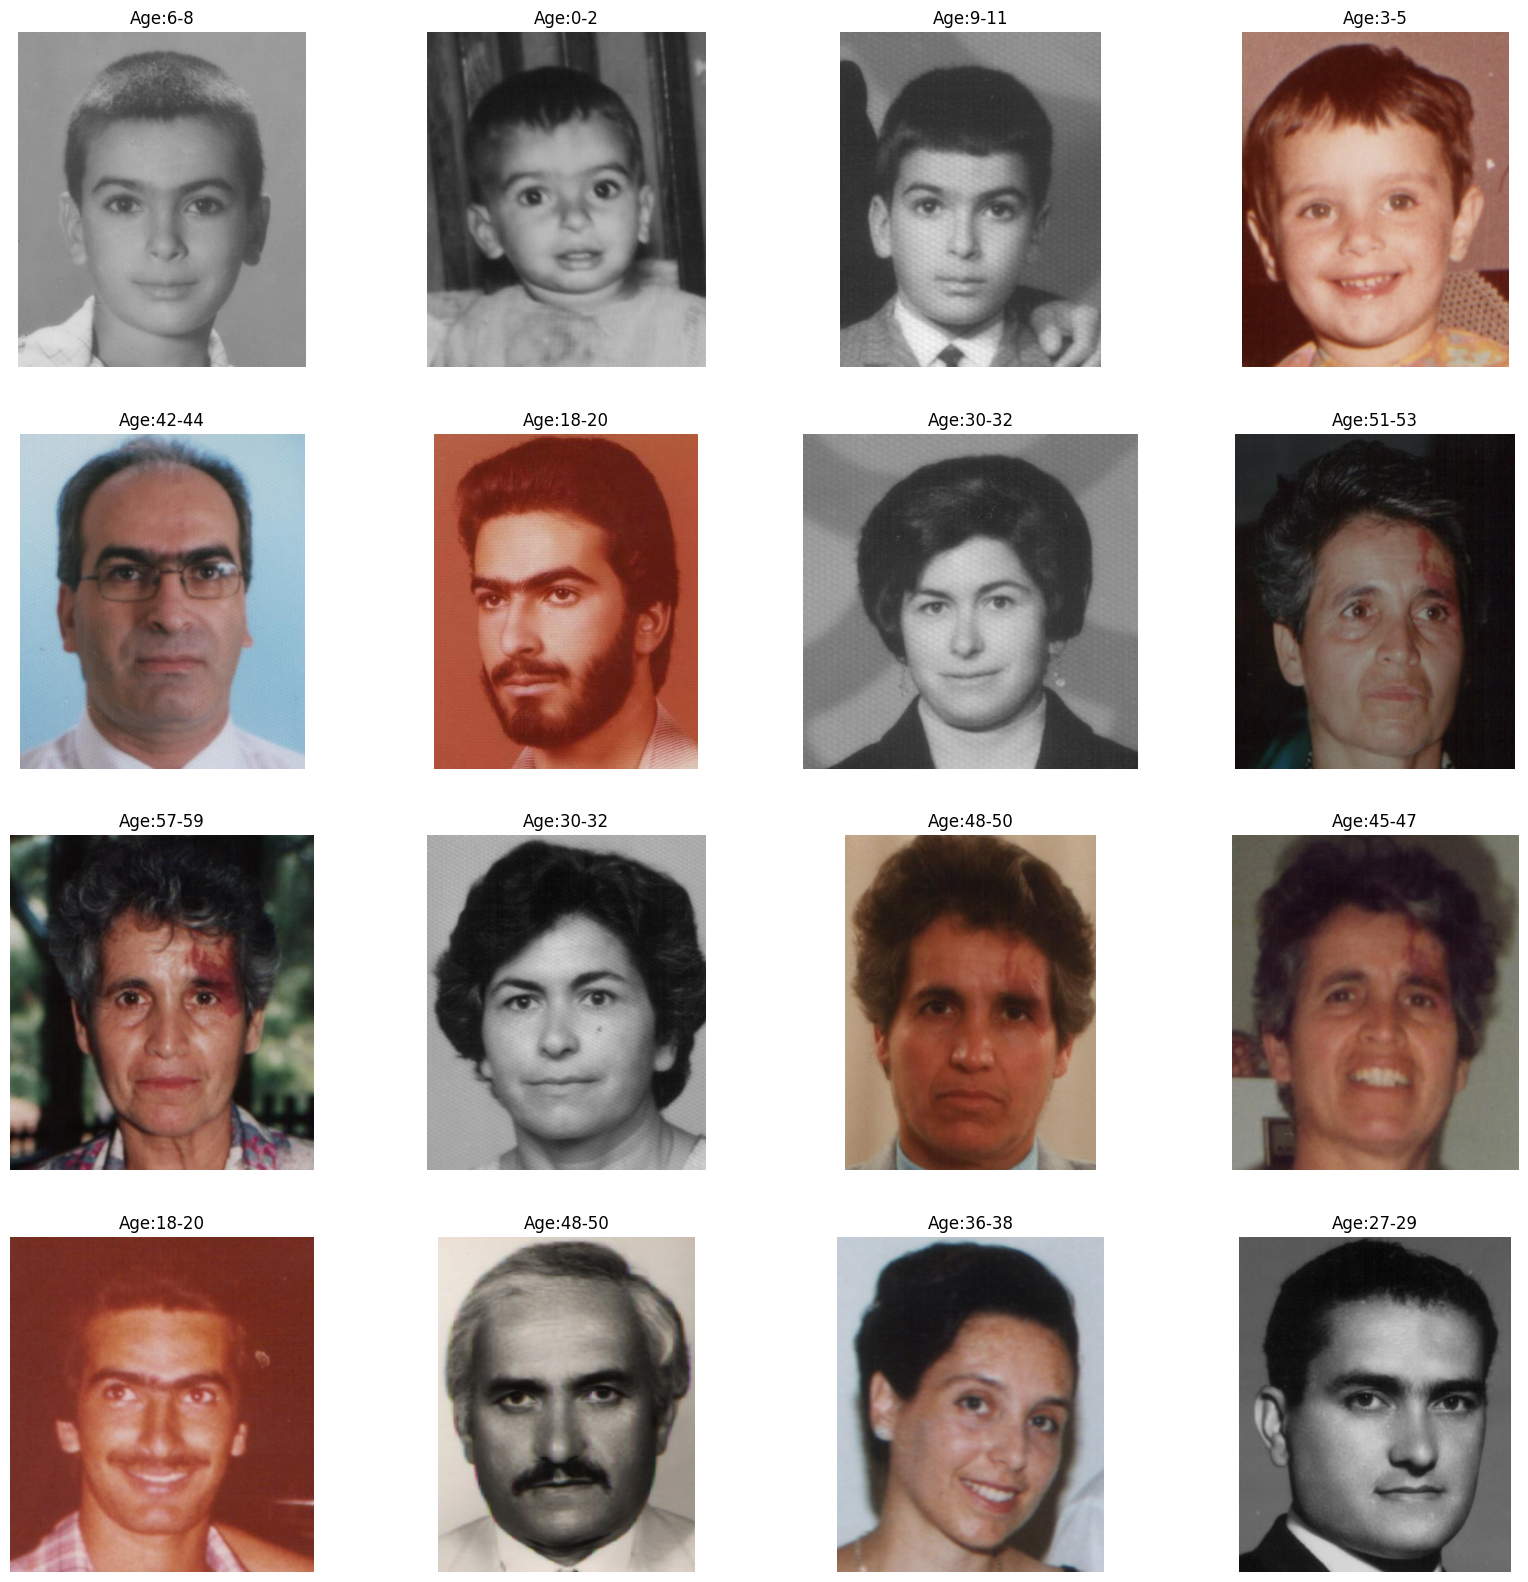

In [12]:
plt.figure(figsize=(20,20))
samples = df.iloc[0:16]

for index,sample,age in samples.itertuples():
  plt.subplot(4,4,index+1)
  img = load_img(sample)
  img = np.array(img)
  plt.axis('off')
  plt.title(f'Age:{age}')
  plt.imshow(img)

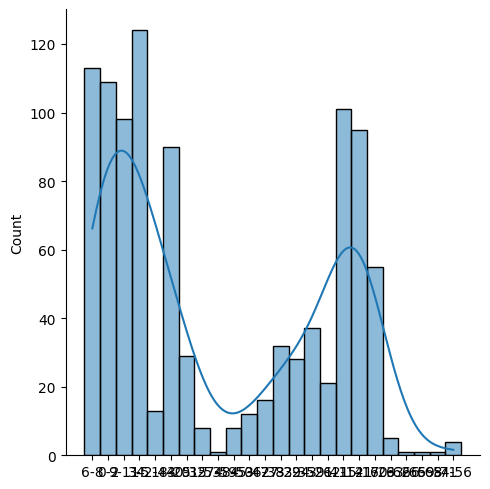

In [13]:
#age distribution
sns.displot(data=age_intervals,kde=True)

In [14]:
train_images, test_images, train_age_groups, test_age_groups = train_test_split(images, age_labels, test_size=0.2, random_state=42)


In [15]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(132, activation='relu')(x)
predictions = Dense(np.max(age_groups) + 1, activation='softmax')(x)

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 [==============================] - 5s 0us/step


In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Dataset/Dataset2/model-weights/D2_CNN1_A1.h5',  # Filepath to save the best model
    monitor='val_accuracy',  # Metric to monitor
    verbose=1,
    save_best_only=True,  # Only save the best model
    mode='max'  # Mode to determine best (maximizing validation accuracy)
)


In [17]:
model.fit(train_images, train_age_groups, validation_split=0.2, epochs=60, batch_size=32, callbacks=[early_stopping, model_checkpoint], shuffle=False)


Epoch 1/60
20/20 [==============================] - ETA: 0s - loss: 2.7642 - accuracy: 0.1547
Epoch 1: val_accuracy improved from -inf to 0.18012, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/D2_CNN1_A1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 46s 410ms/step - loss: 2.7642 - accuracy: 0.1547 - val_loss: 2.8557 - val_accuracy: 0.1801
Epoch 2/60
20/20 [==============================] - ETA: 0s - loss: 1.0092 - accuracy: 0.8297
Epoch 2: val_accuracy did not improve from 0.18012
20/20 [==============================] - 3s 173ms/step - loss: 1.0092 - accuracy: 0.8297 - val_loss: 2.9515 - val_accuracy: 0.1801
Epoch 3/60
20/20 [==============================] - ETA: 0s - loss: 0.2669 - accuracy: 0.9937
Epoch 3: val_accuracy did not improve from 0.18012
20/20 [==============================] - 3s 173ms/step - loss: 0.2669 - accuracy: 0.9937 - val_loss: 2.9741 - val_accuracy: 0.1739
Epoch 4/60
20/20 [==============================] - ETA: 0s - loss: 0.0658 - accuracy: 1.0000
Epoch 4: val_accuracy improved from 0.18012 to 0.19255, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/D2_CNN1_A1.h5
20/20 [==============================] - 5s 245ms/step - loss: 0.0658 - accuracy: 

In [18]:
# Load the best model
model.load_weights('/content/drive/MyDrive/Dataset/Dataset2/model-weights/D2_CNN1_A1.h5')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_age_groups)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


7/7 [==============================] - 1s 149ms/step - loss: 2.9213 - accuracy: 0.1443
Test Accuracy: 14.43%


In [19]:

predictions = model.predict(test_images)

# Convert predictions to class labels if needed
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_age_groups, axis=1)

7/7 [==============================] - 1s 48ms/step


In [20]:
# Example metrics calculation
from sklearn.metrics import classification_report

print(classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.16      1.00      0.27        12
           1       0.00      0.00      0.00        26
           2       0.14      0.17      0.15        24
           3       0.27      0.16      0.20        19
           4       0.00      0.00      0.00        15
           5       0.22      0.07      0.11        28
           6       0.16      0.40      0.23        20
           7       0.00      0.00      0.00        16
           8       0.00      0.00      0.00         9
           9       0.00      0.00      0.00         6
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         8
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         2
          17       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# Calculate classification metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.14
Precision: 0.10
Recall: 0.14
F1-score: 0.09


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
# Calculate accuracy for each class
class_accuracies = {}
for idx in range(np.max(age_groups) + 1):
    # Filter predictions and true labels for the current class
    mask = (true_classes == idx)
    accuracy = accuracy_score(true_classes[mask], predicted_classes[mask])
    class_accuracies[age_group_to_interval(idx)] = accuracy

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [23]:
# Print accuracy for each class
for age_range, accuracy in class_accuracies.items():
    print(f'Accuracy for age range {age_range}: {accuracy:.2f}')

Accuracy for age range 0-2: 1.00
Accuracy for age range 3-5: 0.00
Accuracy for age range 6-8: 0.17
Accuracy for age range 9-11: 0.16
Accuracy for age range 12-14: 0.00
Accuracy for age range 15-17: 0.07
Accuracy for age range 18-20: 0.40
Accuracy for age range 21-23: 0.00
Accuracy for age range 24-26: 0.00
Accuracy for age range 27-29: 0.00
Accuracy for age range 30-32: 0.00
Accuracy for age range 33-35: 0.00
Accuracy for age range 36-38: 0.00
Accuracy for age range 39-41: 0.00
Accuracy for age range 42-44: 0.00
Accuracy for age range 45-47: 0.00
Accuracy for age range 48-50: 0.00
Accuracy for age range 51-53: 0.00
Accuracy for age range 54-56: 0.00
Accuracy for age range 57-59: nan
Accuracy for age range 60-62: nan
Accuracy for age range 63-65: nan
Accuracy for age range 66-68: 0.00
Accuracy for age range 69-71: 0.00
